# Semantic Segmentation with PyTorch

In this exercise, you'll use the U-Net network to perform binary classification and segmentation for images of planes.

> **Important**: Using the U-Net model is resource-intensive. before running the code in this notebook, shut down all other notebooks in this library (In each open notebook other than this one, on the **File** menu, click **Close and Halt**). If you experience and Out-of-Memory (OOM) error when running code in this notebook, shut down this entire library, and then reopen it and open only this notebook.

## Install PyTorch

To begin with, we'll install the latest version of PyTorch, and import the libraries we need.

> *Note: The following `pip install` commands install the CPU-based version of PyTorch on Linux, which is appropriate for the Azure Notebooks environment. For instructions on how to install the PyTorch and TorchVision packages on your own system, see https://pytorch.org/get-started/locally/*

In [1]:
# Install PyTorch
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as td
print("Libraries imported - ready to use PyTorch", torch.__version__)

     |████████████████████████████████| 67.1MB 9.0kB/s eta 0:00:012   |█▍                              | 3.0MB 3.6MB/s eta 0:00:18��███████████▏            | 40.2MB 786kB/s eta 0:00:35kB/s eta 0:00:30�█████████▊          | 45.5MB 14.0MB/s eta 0:00:02��█████████████████████▎         | 46.6MB 14.0MB/s eta 0:00:02��██████████████████████         | 48.1MB 14.0MB/s eta 0:00:02██████████████▍       | 51.1MB 2.5MB/s eta 0:00:07�████████████▋      | 53.8MB 2.5MB/s eta 0:00:06████████████████████████▌     | 55.7MB 8.6MB/s eta 0:00:02MB/s eta 0:00:02    | 58.7MB 8.6MB/s eta 0:00:01�██████▏  | 61.0MB 5.2MB/s eta 0:00:02��██████████████████▎ | 63.4MB 5.2MB/s eta 0:00:01
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
Libraries imported - ready to use PyTorch 1.0.1.post2


## Import the U-Net Code

The code to implement U-Net is provided in the **model.py** python file.

> **Tip**: You should explore the code in this file to get a better understanding of the way the model works.


In [2]:
from unet_pytorch.model import *

## Explore the Training Data

The training data for a U-Net model consists of two kinds of input:

- **Image files**: The images that represent the *features* on which we want to train the model.
- **Mask files**: Images of the object masks that the network will be trained to predict - these are the *labels*.

In this example, we're going to use U-Net for binary classification of airplanes images, so there's only one class of object - and therefore one class of mask. We've deliberately made this example as simple as possible, partly to make it easier to understand what's going on, and partly to ensure it can be run in a resource-constrained environment. 

Let's take a look at the training images and masks:

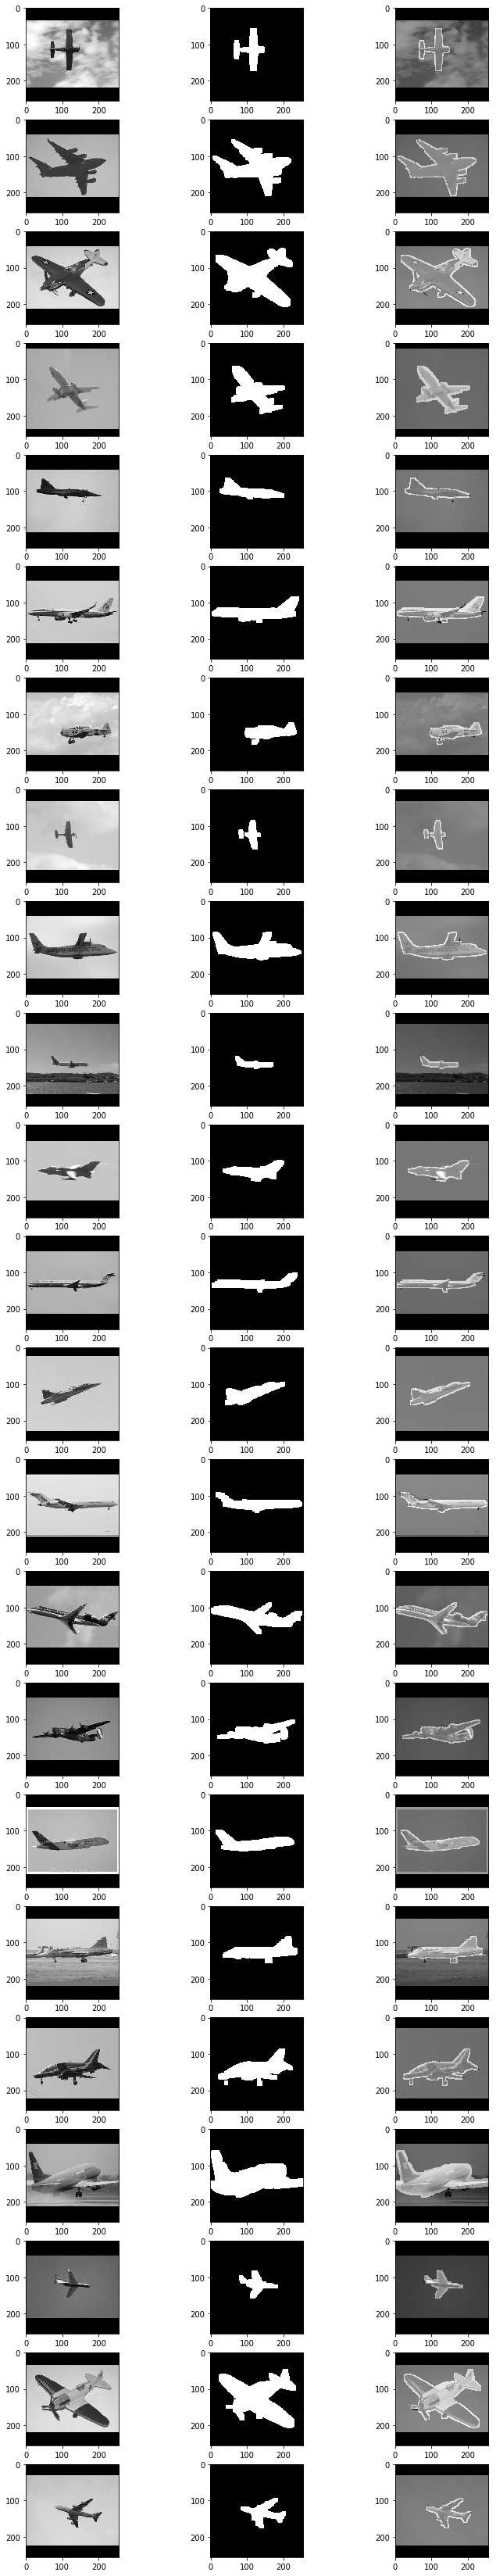

In [3]:
import os
from matplotlib import pyplot as plt
import skimage.io as io
import numpy as np
%matplotlib inline


fig = plt.figure(figsize=(12, 60))

train_dir = '../../data/segmentation/train'
image_dir = os.path.join(train_dir,"image/plane")
mask_dir = os.path.join(train_dir,"mask/plane")

files = os.listdir(image_dir)
rows = len(files)
cell = 0
for file in files:
    cell += 1
    
    # Open the image and mask files
    img_path = os.path.join(image_dir, file)
    img = io.imread(img_path, as_gray = True)
    
    mask_path = os.path.join(mask_dir, file)
    mask = io.imread(mask_path, as_gray = True)
    
    # plot the image
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    cell += 1

    # plot the mask
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(mask, "gray")
    cell += 1
    
    # Plot them overlaid
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    imgplot=plt.imshow(mask, "gray", alpha=0.4)

plt.show()



## Load the Training Data

To load the images, we'll define a custom PyTorch dataset that gets each image and its corresponding mask.

We have a very small number of training images, so we'll apply some data augmentation to randomly flip the images.

In [4]:
class PlaneDataSet(td.Dataset):
    
    def __init__(self, image_path, mask_path):
        import os
        
        self.image_path = image_path
        self.mask_path = mask_path
        self.filenames = os.listdir(mask_path)
        
    def __getitem__(self, index):
        import os
        import random
        import numpy as np
        from PIL import Image
        import skimage.io as io
        
        # Get a random intenger between 1 and 2
        rand = random.randint(0, 2)     
        
        #Load the image
        img_path = os.path.join(self.image_path, self.filenames[index])
        image =  io.imread(img_path, as_gray = True)
        
        # Normalize the image pixels between 0 and 1
        image_np = image/255
        
        # Randomly flip the image half the time
        if rand > 1:
            image_pil = Image.fromarray(image_np).transpose(Image.FLIP_LEFT_RIGHT).convert("L")          
            image_np = np.array(image_pil)
        
        # Add a dimension and convert to a tensor
        image_np = np.expand_dims(image_np, axis=0)
        image_tensor = torch.Tensor(image_np)
        
        # Now do all the same stuff to the mask image
        mask_path = os.path.join(self.mask_path, self.filenames[index])
        mask =  io.imread(mask_path, as_gray = True)
        mask_np = mask/255
        if rand > 1:
            mask_pil = Image.fromarray(mask_np).transpose(Image.FLIP_LEFT_RIGHT).convert("L")            
            mask_np = np.array(mask_pil)
        mask_np = np.expand_dims(mask_np, axis=0)
        mask_tensor = torch.Tensor(mask_np)
        
        return(image_tensor, mask_tensor)
    
    def __len__(self):
        return len(self.filenames)
                           
     

Now we can use our dataset to create a data loader that gets batches of training data.

In [5]:
# Function to ingest data
def load_data(image_path, mask_path):

    # Load all of the images, transforming them
    dataset = PlaneDataSet(image_path , mask_path)
    
    # define a loader for the image data
    image_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=2,
        num_workers=0,
        shuffle=True
    )
    
        
    return image_loader

image_loader = load_data(image_dir, mask_dir)


## Download the Model Weights
The model has already been partially trained, so we'll download the trained weights as a starting point.

In [6]:
!wget "https://aka.ms/unet-pt" -O ~/unet.pt

--2020-04-25 20:32:32--  https://aka.ms/unet-pt
Resolving webproxy (webproxy)... 10.36.29.1
Connecting to webproxy (webproxy)|10.36.29.1|:3128... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: https://onedrive.live.com/download?cid=783D202C58C75CC2&resid=783D202C58C75CC2%21106&authkey=AC-jDrEgK0Phd6E [following]
--2020-04-25 20:32:32--  https://onedrive.live.com/download?cid=783D202C58C75CC2&resid=783D202C58C75CC2%21106&authkey=AC-jDrEgK0Phd6E
Connecting to webproxy (webproxy)|10.36.29.1|:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://asm0nq.bn.files.1drv.com/y4mSCIaXfRSTor4tOGxoMWuxR1Can61H6iczqeoWOy19KapbuAlVpKg8w3CGjMoc1a3T5zxpTlrrZVRlnPPiJdT6kDOyfuOCSotYLKPnYW2YQsF-KN0IuQZtbwzscBhHT8lzTt37URi36dcPLGhRwtipHdTqvtBKU4jUjsDLgkD2i1L0jtsGma4vF2CkACt2uYFSwrrQh7syyGJDBSzww_7rg/unet.pt?download&psid=1 [following]
--2020-04-25 20:32:33--  https://asm0nq.bn.files.1drv.com/y4mSCIaXfRSTor4tOGxoMWuxR1Can61H6iczqeoWOy19

## Train the Model

Now we're ready to train the U-Net model. We'll train it from the data loader we created.

After training is complete, we'll save the model weights.

> _**Note**: This will take a while on a non-GPU machine - go get some coffee!_

In [ ]:
def train(model, device, data_loader, optimizer, epoch):
    
    model.to(device)
    model.train()
    
    train_loss = 0
    print("Epoch:", epoch, "...")
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(data_loader):
        
        
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_training_loss = train_loss / (batch_idx+1)
    print("\tTraining set: Average loss: {:.6f}".format(avg_training_loss))
    return avg_training_loss

# Create a UNet model
model = UNet(n_channels=1, n_classes = 1)

# Use the best available device (GPU/CPU) for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the weights
home = os.path.expanduser("~")
weights_file = os.path.join(home, "unet.pt")
model.load_state_dict(torch.load(weights_file, map_location=device))

# Specify the optimizer and  loss criteria
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_criteria = nn.BCELoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []

epochs = 2
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, image_loader, optimizer, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)

# Save the model weights
torch.save(model.state_dict(), weights_file)
print("Model saved.")

Training on cpu
Epoch: 1 ...
	Training set: Average loss: 0.155333
Epoch: 2 ...


## Test the Trained Model

OK, let's see how well our trained model does with some images of airplanes it hasn't seen.

In [ ]:
import os
from matplotlib import pyplot as plt
import skimage.io as io
from unet_pytorch.model import *
import numpy as np
%matplotlib inline

#Create a new instance of the model and load the saved weights
model = UNet(n_channels=1, n_classes = 1)
home = os.path.expanduser("~")
weights_file = os.path.join(home, "unet.pt")
model.load_state_dict(torch.load(weights_file, map_location='cpu'))
model.eval()

fig = plt.figure(figsize=(12, 60))

test_dir = '../../data/segmentation/test'

files = os.listdir(test_dir)
rows = len(files)
cell = 0
for file in files:
    cell += 1
    # Open the file
    img_path = os.path.join(test_dir, file)
    img =  io.imread(img_path, as_gray = True)
    
    # Normalize and convert to a tensor array
    image_tensor = torch.stack([torch.Tensor(img/255).unsqueeze(0)])
    
    # Plot the original image
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    cell += 1
    
    # Get the predicted mask and plot it
    with torch.no_grad():
        mask_predictions = model(image_tensor)
    mask = mask_predictions.data.numpy()[0]
    img_mask = mask[0]
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img_mask, "gray")
    cell += 1
    
    # Plot the mask overlaid on the image
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    imgplot=plt.imshow(img_mask, "binary", alpha=0.7)

plt.show()

It's not fantastic, largely because we used such a small amount of data; but hopefully it serves to demonstrate the principles of semantic segmentation with U-Net.

## Acknowledgements and Citations

The U-Net architecture is documented by its inventors (Olaf Ronneberger, Philipp Fischer, and Thomas Brox), at https://arxiv.org/abs/1505.04597.

The PyTorch implementation of U-Net used in this exercise is based on milesial's work at https://github.com/milesial/Pytorch-UNet, with some simplifications. 

The data used in this exercise includes images adapted from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.


    @misc{pascal-voc-2007,
        author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
        title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
        howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}

